In [3]:
!pip install tensorflow
!pip install langdetect


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


--------------------------
# Modèle CNN - Score (étoiles)
- Lucie MASSELIN
--------------------------

## 1. Chargement et échantillonnage

In [1]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\S6C01-test\data\yelp_academic_reviews4students.jsonl'

# Chercher si il trouve le fichier
if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# Compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)

Fichier trouvé. Taille : 719.56 Mo
Nombre de lignes (avis) : 1000000


In [3]:
import pandas as pd

# Trouver + limiter le nombre de ligne de facon aléatoire
df_review = pd.read_json(FILE_PATH, lines=True)
df_sample = df_review.sample(n = 50000, random_state = 42) 
print(f"Nombre de lignes dans df_sample : {len(df_sample)} avis")

Nombre de lignes dans df_sample : 50000 avis


## 2. Pré traitement

Vérification taille, type de données du dataset

In [5]:
df_sample.shape

(50000, 9)

Types variables + analyse données manquantes

In [13]:
df_sample.dtypes

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object

In [9]:
print((df_sample.isnull().sum()).sort_values(ascending=False))

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [15]:
df_sample.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
987231,57Xa8920BrAjNOfqPgFt4Q,xeg77-uLosYTkH76CO9ftg,_C7QiQQc47AOEv4PE3Kong,1,0,0,0,I'm not quite sure what the hype is all about ...,2015-05-25 01:45:08
79954,Edkm3QufPBZTxtiWvTjcsQ,5rWHGgu3QRQMChUjHmZ6EQ,MxRZHZoDVVnN7EvMAHf1EA,5,0,0,0,Fleming's for a special occasion or just dinne...,2019-01-06 00:36:10


In [4]:
df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True) # Supprimer les valeurs manquantes 

print("Shape:", df.shape)
df.head(10)

Shape: (50000, 4)


,review_id,business_id,stars,text
0,57Xa8920BrAjNOfqPgFt4Q,_C7QiQQc47AOEv4PE3Kong,1,I'm not quite sure what the hype is all about ...
1,Edkm3QufPBZTxtiWvTjcsQ,MxRZHZoDVVnN7EvMAHf1EA,5,Fleming's for a special occasion or just dinne...
2,HL6_YRk1ZKzfsF_2it7jFg,wu2nJ5lW0tCU3VYa80i8Uw,4,We found this location clean and well-kept. I ...
3,cYp4OouZBSsup6YE1CR73A,u-PhwpLtNmNIjOPo3jTjfw,5,My husband has been coming here for a few year...
4,WzgGRZVVI9HvR-2QCOTtHQ,yK8LWJ4VRTYEoGxVYzcjQg,1,Been here twice since they've opened. Was cert...
5,fyRZd1jVRkrsWs33llCONQ,MOowZBGbgn7FrTol3dvrlg,4,I was pleasantly surprised during our first vi...
6,UgzM4JQOiz-GfAwH3r6OdA,y930pQM0EUblQluRLkXLQg,5,We are very particular about our food . My hus...
7,NJKEs91GuNZVdz6TZTCQWg,IK4iU_hsbzLPbRhZRv1jrw,1,This is a halfway descent motel 6 but there's ...
8,3xU7xswtkPZzN3zSf5fKHg,34Eqv8jXgxg_EEwcsNgeeg,5,We tried looking for some brunch places that w...
9,prYct0PPAkOvUtl3ShDUWw,4r6N_Fhiwoqo_FqQ7Mm6mQ,5,Came back to Tucson to visit family and I'm go...


## 3. Visualisation polarité des scores (étoiles)

In [5]:
score = df["stars"].value_counts(normalize=True)
print("Distribution des classes :")
print(score.map('{:.4f}'.format))

Distribution des classes :
stars
5    0.4620
4    0.2082
1    0.1555
3    0.0974
2    0.0769
Name: proportion, dtype: object


In [5]:
import re
from langdetect import detect, LangDetectException

def stars_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Application sur le dataframe
print("Détection de la langue en cours (ça peut prendre quelques secondes)")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels")
df["label"] = df["stars"].apply(stars_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)
Avant filtrage : 50000 avis
Après filtrage (Anglais uniquement) : 49943 avis
Nettoyage des textes et création des labels


,stars,label,text_clean
0,1,négatif,i'm not quite sure what the hype is all about ...
1,5,positif,fleming's for a special occasion or just dinne...
2,4,positif,we found this location clean and well kept i o...
3,5,positif,my husband has been coming here for a few year...
4,1,négatif,been here twice since they've opened was certa...
5,4,positif,i was pleasantly surprised during our first vi...
6,5,positif,we are very particular about our food my husba...
7,1,négatif,this is a halfway descent motel but there's a ...
8,5,positif,we tried looking for some brunch places that w...
9,5,positif,came back to tucson to visit family and i'm go...


## 4. Attribution de classe pour les étoiles
Ca a peut être servit à rien

In [6]:
from sklearn.preprocessing import LabelEncoder

# Transformer les étoiles en nombre entier pour attribuer un classe 0 
le = LabelEncoder()
df["stars_encoded"] = le.fit_transform(df["stars"])

NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4)}


## 5. Séparation données Train/Test

In [8]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['stars_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des notes (Rating) :")
rating_pct = df['stars_encoded'].value_counts(normalize=True).sort_index()
print(rating_pct.map('{:.4f}'.format))

Répartition des notes (Rating) :
stars_encoded
0    0.1561
1    0.0797
2    0.0962
3    0.2088
4    0.4592
Name: proportion, dtype: object


------
## Explication utilisation Tokenizer
Les représentations de texte comme tf-idf , bm25 et sac de mots ne marchent pas avec une architecture CNN standard a la place j'utilise des tokenizer + embedding (transforme) pour :
- Le modèle ne sait pas lire des mots ("Food", "Bad"). Il ne comprend que des chiffres
- Le Tokenizer sert à construire un dictionnaire numéroté unique à ton dataset

------

EX: 
- Phrase : "The food was good"
- Sortie du Tokenizer : [1, 25, 12, 42]

------

### Tokenizer : Met les mots dans l'ordre et leur donne un numéro.

### Embedding : Donne du sens aux mots en les transformant en coordonnées mathématiques intelligentes.

------

- CNN : Il a besoin de lire la séquence pour appliquer ses filtres (ses "lunettes")
- BoW / BM25 / TF-IDF : Ce sont des méthodes "Bag of Words". Elles mélangent tous les mots dans un sac

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight

MAX_WORDS = 20000
MAX_LEN = 100

print("Tokenisation des textes pour le CNN")
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_raw) # On apprend le vocabulaire sur le train

# Transformation du texte en suites de chiffres
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Padding (Toutes les phrases doivent faire la même longueur)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"Dimension des données CNN : {X_train_pad.shape}")

# Calcul des poids
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

Tokenisation des textes pour le CNN
Dimension des données CNN : (39956, 100)


## 6. Application du Modèle CNN

In [21]:
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model_cnn = Sequential([
    # Couche 1 : Embedding (Transforme les chiffres en vecteurs de sens)
    Embedding(input_dim=MAX_WORDS, output_dim=50, input_length=MAX_LEN),
    
    # Couche 2 : Convolution 1D - partie lecture
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    
    # Pour réduire un peu la taille avant la 2ème lecture
    MaxPooling1D(pool_size=2),
    
    # Bloc Conv 2 (Il relit les motifs trouvés par le Bloc 1)
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    
    # Garde uniquement l'information la plus forte
    GlobalMaxPooling1D(),
    
    # Plus de neurones pour une rélfexion plus large
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Couche 3 : Dense (Classification) - partie reflexion
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(NUM_CLASSES, activation='softmax')
])

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

c:\Users\lucie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    restore_best_weights=True
)

print("\nDébut de l'entraînement du CNN")
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10, 
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Début de l'entraînement du CNN
Epoch 1/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4562 - loss: 1.3030 - val_accuracy: 0.6040 - val_loss: 0.9649
Epoch 2/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6117 - loss: 0.9903 - val_accuracy: 0.5681 - val_loss: 0.9700
Epoch 3/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6662 - loss: 0.8383 - val_accuracy: 0.5628 - val_loss: 0.9707
Epoch 4/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7166 - loss: 0.6962 - val_accuracy: 0.6131 - val_loss: 0.9810


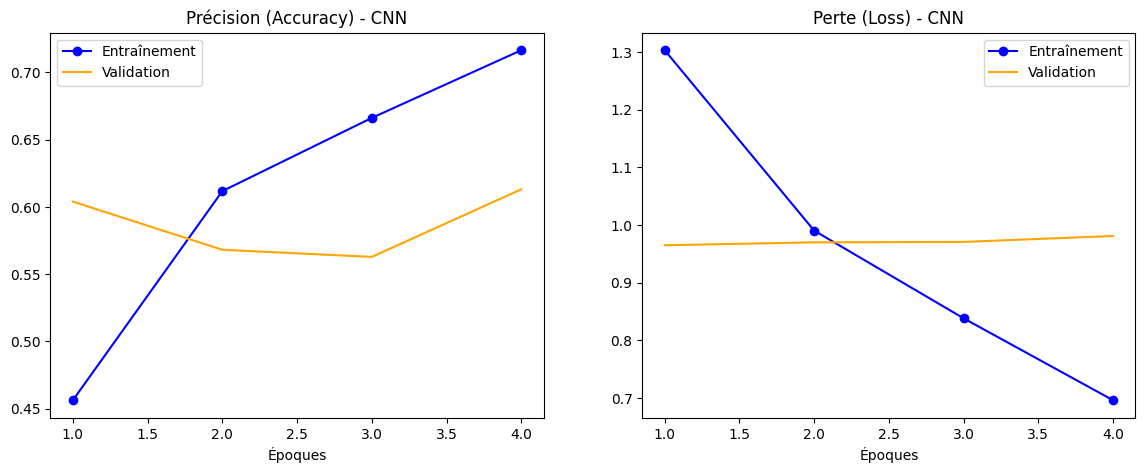


--- Evaluation Finale CNN ---


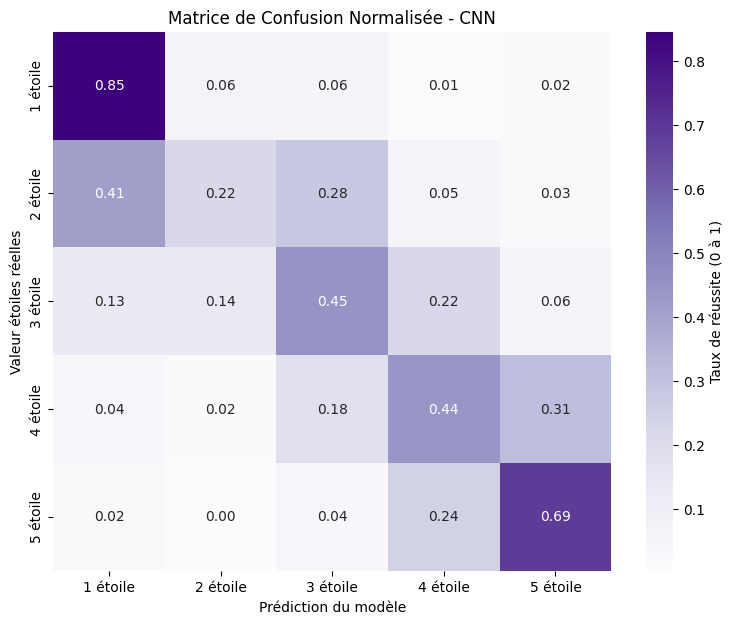

Précision (Accuracy) : 0.6040
F1-Score (Ajusté selon la quantité d'avis par étoile) : 0.6077
Perte (Log Loss)     : 0.9649

Rapport détaillé :
              precision    recall  f1-score   support

    1 étoile       0.67      0.85      0.75      1534
    2 étoile       0.38      0.22      0.28       761
    3 étoile       0.32      0.45      0.37       918
    4 étoile       0.40      0.44      0.42      2082
    5 étoile       0.81      0.69      0.74      4694

    accuracy                           0.60      9989
   macro avg       0.51      0.53      0.51      9989
weighted avg       0.62      0.60      0.61      9989



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns


acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_acc, 'orange', label='Validation')
plt.title('Précision (Accuracy) - CNN')
plt.xlabel('Époques')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_loss, 'orange', label='Validation')
plt.title('Perte (Loss) - CNN')
plt.xlabel('Époques')
plt.legend()
plt.show()

print("\n--- Evaluation Finale CNN étoiles ---")

# Matrice de Confusion (Corrélation)
y_pred_probs = model_cnn.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [f"{star} étoile" for star in le.classes_]

plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f', 
            cmap='Purples',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Taux de réussite (0 à 1)'})

plt.title('Matrice de Confusion Normalisée - CNN')
plt.xlabel('Prédiction du modèle')
plt.ylabel('Valeur étoiles réelles')
plt.show()

# Calcul des métriques spécifiques au CNN
acc_cnn = accuracy_score(y_test, y_pred)
f1_cnn = f1_score(y_test, y_pred, average='weighted')
loss_cnn = log_loss(y_test, y_pred_probs)


print(f"Précision (Accuracy) : {acc_cnn:.4f}")
print(f"F1-Score (Ajusté selon la quantité d'avis par étoile) : {f1_cnn:.4f}")
print(f"Perte (Log Loss)     : {loss_cnn:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=class_names))

----------
## 7. Test phrase

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Fonction adaptée pour le CNN
def predict_custom_sentence_cnn(text, model, tokenizer, stars_encoder, max_len=100):
    text_clean = clean_text(text) # Nettoyage (Le même que pour l'entraînement)
    seq = tokenizer.texts_to_sequences([text_clean]) # Transformation (Texte -> Séquence d'entiers)
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post') # Padding (Ajout de zéros pour atteindre 100 mots)
    prediction_probs = model.predict(padded, verbose=0) # Prédiction
    predicted_index = np.argmax(prediction_probs) # Décodage
    predicted_stars = stars_encoder.inverse_transform([predicted_index])[0]
    
    print(f"Phrase : \"{text}\"")
    print(f"Prédiction des étoiles : {predicted_stars}")
    print(f"Confiance : {prediction_probs[0][predicted_index]:.2f}")
    print("-" * 30)

# ZONE DE TEST
phrases_a_tester = [
    "The food was amazing and the service was perfect!", 
    "It was terrible, I will never come back.", 
    "The food was okay but a bit expensive.", 
    "I don't know what to think about this place." 
]

print("TEST DU MODÈLE CNN \n")
for phrase in phrases_a_tester:
    predict_custom_sentence_cnn(phrase, model_cnn, tokenizer, le)

TEST DU MODÈLE CNN 

Phrase : "The food was amazing and the service was perfect!"
Prédiction des étoiles : 5
Confiance : 0.65
------------------------------
Phrase : "It was terrible, I will never come back."
Prédiction des étoiles : 1
Confiance : 0.78
------------------------------
Phrase : "The food was okay but a bit expensive."
Prédiction des étoiles : 3
Confiance : 0.46
------------------------------
Phrase : "I don't know what to think about this place."
Prédiction des étoiles : 3
Confiance : 0.24
------------------------------
